# Survey Completion Rate Report

Analysis of completion rates for AI Resources survey data.

## Key Metrics:
1. Ratio of users who filled the "AI Resources Used" column
2. Ratio of "AI Resources Used" containing specific resources (Books, Deeplearning.ai, Youtube, Udemy, Coursera, Maven)
3. Among group 2, how many provided links

In [35]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_loader import load_google_sheet_csv, load_local_data, preview_data
import re
from datetime import datetime
from pathlib import Path
import glob
import requests
from urllib.parse import urlparse, urljoin
import time
from bs4 import BeautifulSoup
import tldextract
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Load and Preview Data

In [36]:
# Load data from Google Sheets
sheet_id = "1wPaM5TPKRj4pNZK75XaBLRUIeIBoJ_MwD2_Sed5W6Hk"
df = load_google_sheet_csv(sheet_id)

# If Google Sheets fails, try loading from local file
if df is None:
    print("\nTrying to load from local file...")
    # Uncomment and modify filename as needed:
    df = load_local_data('CSP AI Culture and Learning_ Tracking - People and AI Info_2025-10-17.csv')
    
if df is not None:
    print("\n=== DATA LOADED SUCCESSFULLY ===")
    preview_data(df, n_rows=3)
else:
    print("\n❌ Could not load data. Please:")
    print("1. Make the Google Sheet public ('Anyone with link can view'), or")
    print("2. Download as CSV and place in data/ folder")

Error accessing Google Sheet: 401 Client Error: Unauthorized for url: https://docs.google.com/spreadsheets/d/1wPaM5TPKRj4pNZK75XaBLRUIeIBoJ_MwD2_Sed5W6Hk/export?format=csv&gid=0
Make sure the sheet is public (Anyone with link can view)

Trying to load from local file...
Data loaded successfully: 218 rows, 7 columns

=== DATA LOADED SUCCESSFULLY ===

=== DATA PREVIEW ===
Shape: (218, 7)

Columns: ['Name', 'Manager', 'AI Resources Used', 'References / Links', 'email', 'Sept Survey', 'Expensed']

First 3 rows:
               Name              Manager  \
0  Aishwarya Nirmal  Kevin Jungmeisteris   
1        Akhil Ojha          Prerna Arya   
2    Aleck Landgraf        Darrick Brown   

                                   AI Resources Used  \
0  Books, Coursera, Claude, GleanChat, OneChat (A...   
1                                                NaN   
2  Claude, ChatGPT, Gemini, GleanChat, OneChat (A...   

                                  References / Links  \
0  O'Reilly AI Engineering: h

## Load Previous Report for Comparison

In [37]:
# Load most recent previous report for comparison
def load_previous_report():
    """Load the most recent completion rate report for comparison"""
    output_dir = Path('../outputs')
    if not output_dir.exists():
        return None
    
    # Find all previous completion rate reports
    report_files = list(output_dir.glob('completion_rate_report_*.csv'))
    
    if not report_files:
        print("📋 No previous reports found. This will be the baseline report.")
        return None
    
    # Get the most recent report
    latest_report = max(report_files, key=lambda x: x.stat().st_mtime)
    
    try:
        previous_df = pd.read_csv(latest_report)
        report_date = latest_report.stem.split('_')[-2] + '_' + latest_report.stem.split('_')[-1]
        print(f"📊 Previous report loaded: {latest_report.name}")
        print(f"📅 Report date: {report_date}")
        return previous_df
    except Exception as e:
        print(f"⚠️  Error loading previous report: {e}")
        return None

# Load previous report
previous_report = load_previous_report()

📋 No previous reports found. This will be the baseline report.


## Identify Key Columns

Let's identify which columns contain the data we need to analyze.

In [38]:
if df is not None:
    print("=== COLUMN ANALYSIS ===")
    print(f"Total columns: {len(df.columns)}")
    print("\nColumn names with indices:")
    for i, col in enumerate(df.columns):
        print(f"  {i}: '{col}'")
    
    # Try to identify AI Resources column automatically
    ai_resources_col = None
    link_provided_col = None
    
    for i, col in enumerate(df.columns):
        col_lower = str(col).lower()
        if 'ai' in col_lower and 'resource' in col_lower:
            ai_resources_col = col
            print(f"\n✅ Found AI Resources column: '{col}' (index {i})")
        if 'link' in col_lower or (i == 3):  # Look for 'link' keyword or assume index 3
            link_provided_col = col
            print(f"✅ Link provided column identified as: '{col}' (index {i})")
    
    if ai_resources_col is None:
        print("\n⚠️  Could not automatically identify AI Resources column.")
        print("Please manually set the column name below.")
    
    if link_provided_col is None and len(df.columns) > 3:
        link_provided_col = df.columns[3]
        print(f"\n✅ Assuming Link provided column is: '{link_provided_col}' (index 3)")

=== COLUMN ANALYSIS ===
Total columns: 7

Column names with indices:
  0: 'Name'
  1: 'Manager'
  2: 'AI Resources Used'
  3: 'References / Links'
  4: 'email'
  5: 'Sept Survey'
  6: 'Expensed'

✅ Found AI Resources column: 'AI Resources Used' (index 2)
✅ Link provided column identified as: 'References / Links' (index 3)


In [39]:
# Manual column configuration (update these if auto-detection failed)
if df is not None:
    # Update these column names based on your actual data:
    if ai_resources_col is None:
        # Manually set the AI Resources column name here
        ai_resources_col = "AI Resources Used"  # Update this name
    
    if link_provided_col is None:
        # Manually set Link provided column name here
        link_provided_col = df.columns[3] if len(df.columns) > 3 else "Link provided"  # Update this
    
    print(f"Using AI Resources column: '{ai_resources_col}'")
    print(f"Using Link provided column: '{link_provided_col}'")
    
    # Check if columns exist
    if ai_resources_col not in df.columns:
        print(f"\n❌ Warning: '{ai_resources_col}' not found in columns!")
        print("Available columns:", list(df.columns))
    
    if link_provided_col not in df.columns:
        print(f"\n❌ Warning: '{link_provided_col}' not found in columns!")
        print("Available columns:", list(df.columns))

Using AI Resources column: 'AI Resources Used'
Using Link provided column: 'References / Links'


## Completion Rate Analysis

In [40]:
if df is not None and ai_resources_col in df.columns:
    # Remove completely empty rows
    df_clean = df.dropna(how='all').copy()
    
    print("=== COMPLETION RATE ANALYSIS ===")
    print(f"Total responses (after removing empty rows): {len(df_clean)}")
    
    # Metric 1: Ratio of users who filled AI Resources Used column
    ai_resources_filled = df_clean[ai_resources_col].notna() & (df_clean[ai_resources_col].astype(str).str.strip() != '')
    ai_resources_count = ai_resources_filled.sum()
    ai_resources_ratio = ai_resources_count / len(df_clean) if len(df_clean) > 0 else 0
    
    print(f"\n📊 METRIC 1: AI Resources Used Column Completion")
    print(f"  Users who filled AI Resources Used: {ai_resources_count}/{len(df_clean)}")
    print(f"  Completion ratio: {ai_resources_ratio:.2%}")
    
    # Define target AI resources
    target_resources = ['Books', 'Deeplearning.ai', 'Youtube', 'Udemy', 'Coursera', 'Maven']
    
    # Metric 2: Ratio containing specific AI resources
    if ai_resources_count > 0:
        # Get only the filled AI resources responses
        filled_responses = df_clean[ai_resources_filled][ai_resources_col].astype(str)
        
        # Check which responses contain at least one target resource
        contains_target = filled_responses.apply(lambda x: any(
            resource.lower() in x.lower() for resource in target_resources
        ))
        
        target_count = contains_target.sum()
        target_ratio_of_filled = target_count / ai_resources_count if ai_resources_count > 0 else 0
        target_ratio_of_total = target_count / len(df_clean) if len(df_clean) > 0 else 0
        
        print(f"\n📊 METRIC 2: Specific AI Resources Usage")
        print(f"  Target resources: {', '.join(target_resources)}")
        print(f"  Users with target resources: {target_count}/{ai_resources_count} (of those who filled AI resources)")
        print(f"  Ratio of filled responses: {target_ratio_of_filled:.2%}")
        print(f"  Ratio of total responses: {target_ratio_of_total:.2%}")
        
        # Metric 3: Among those with target resources, how many provided links
        if link_provided_col in df_clean.columns and target_count > 0:
            # Get users who have target resources
            target_users_mask = df_clean[ai_resources_col].astype(str).apply(lambda x: any(
                resource.lower() in x.lower() for resource in target_resources
            )) & ai_resources_filled
            
            target_users_df = df_clean[target_users_mask]
            
            # Check how many of them provided links
            link_provided_filled = target_users_df[link_provided_col].notna() & (target_users_df[link_provided_col].astype(str).str.strip() != '')
            link_provided_count = link_provided_filled.sum()
            link_provided_ratio = link_provided_count / len(target_users_df) if len(target_users_df) > 0 else 0
            
            print(f"\n📊 METRIC 3: Link Provided Completion (among target resource users)")
            print(f"  Users with target resources who provided links: {link_provided_count}/{len(target_users_df)}")
            print(f"  Completion ratio: {link_provided_ratio:.2%}")
        else:
            print(f"\n❌ Cannot calculate Metric 3: Link provided column '{link_provided_col}' not found or no target users")
    else:
        print("\n❌ Cannot calculate Metrics 2 & 3: No AI Resources responses found")
        
else:
    print("❌ Cannot perform analysis: Data not loaded or AI Resources column not found")

=== COMPLETION RATE ANALYSIS ===
Total responses (after removing empty rows): 217

📊 METRIC 1: AI Resources Used Column Completion
  Users who filled AI Resources Used: 121/217
  Completion ratio: 55.76%

📊 METRIC 2: Specific AI Resources Usage
  Target resources: Books, Deeplearning.ai, Youtube, Udemy, Coursera, Maven
  Users with target resources: 58/121 (of those who filled AI resources)
  Ratio of filled responses: 47.93%
  Ratio of total responses: 26.73%

📊 METRIC 3: Link Provided Completion (among target resource users)
  Users with target resources who provided links: 48/58
  Completion ratio: 82.76%


## Detailed Resource Breakdown

=== DETAILED RESOURCE BREAKDOWN ===
  Books: 18 mentions (14.9% of filled responses)
  Deeplearning.ai: 20 mentions (16.5% of filled responses)
  Youtube: 25 mentions (20.7% of filled responses)
  Udemy: 10 mentions (8.3% of filled responses)
  Coursera: 20 mentions (16.5% of filled responses)
  Maven: 1 mentions (0.8% of filled responses)


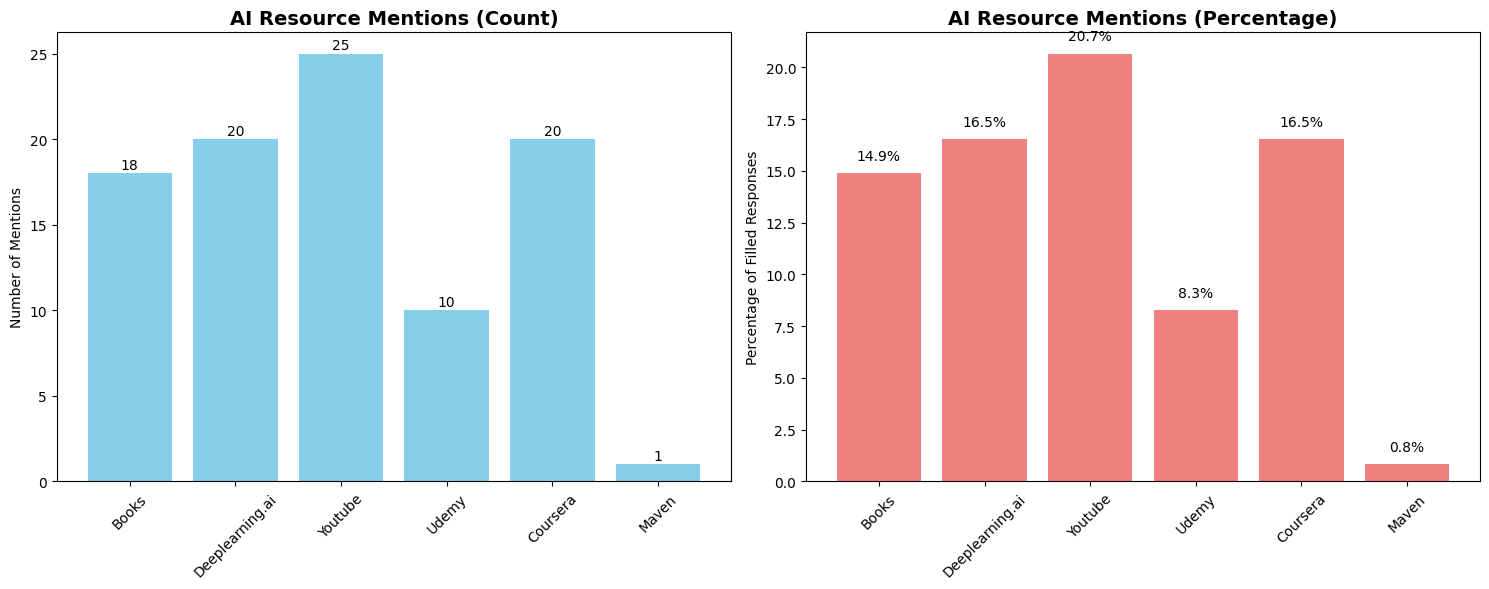

In [41]:
if df is not None and ai_resources_col in df.columns and ai_resources_count > 0:
    print("=== DETAILED RESOURCE BREAKDOWN ===")
    
    # Get filled AI resources responses
    filled_responses = df_clean[ai_resources_filled][ai_resources_col].astype(str)
    
    # Count mentions of each target resource
    resource_counts = {}
    for resource in target_resources:
        count = filled_responses.apply(lambda x: resource.lower() in x.lower()).sum()
        percentage = (count / len(filled_responses)) * 100
        resource_counts[resource] = {'count': count, 'percentage': percentage}
        print(f"  {resource}: {count} mentions ({percentage:.1f}% of filled responses)")
    
    # Visualization
    if len(resource_counts) > 0:
        resources = list(resource_counts.keys())
        counts = [resource_counts[r]['count'] for r in resources]
        percentages = [resource_counts[r]['percentage'] for r in resources]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Bar chart of counts
        bars1 = ax1.bar(resources, counts, color='skyblue')
        ax1.set_title('AI Resource Mentions (Count)', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Number of Mentions')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{int(height)}', ha='center', va='bottom')
        
        # Bar chart of percentages
        bars2 = ax2.bar(resources, percentages, color='lightcoral')
        ax2.set_title('AI Resource Mentions (Percentage)', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Percentage of Filled Responses')
        ax2.tick_params(axis='x', rotation=45)
        
        # Add percentage labels on bars
        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

## Summary Report

In [43]:
if df is not None:
    print("\n" + "="*60)
    print("                COMPLETION RATE SUMMARY REPORT")
    print("="*60)
    print(f"📊 Total Survey Responses: {len(df_clean)}")
    print()
    
    if ai_resources_col in df.columns:
        print(f"1️⃣  AI Resources Used Column Completion:")
        print(f"    ✅ {ai_resources_count:,} users filled the column ({ai_resources_ratio:.1%})")
        print(f"    ❌ {len(df_clean) - ai_resources_count:,} users left it blank ({(1-ai_resources_ratio):.1%})")
        print()
        
        if ai_resources_count > 0:
            print(f"2️⃣  Specific AI Resources Usage:")
            print(f"    📚 Target resources: {', '.join(target_resources)}")
            print(f"    ✅ {target_count:,} users mentioned target resources ({target_ratio_of_filled:.1%} of filled responses)")
            print(f"    📈 This represents {target_ratio_of_total:.1%} of all survey responses")
            print()
            
            if link_provided_col in df_clean.columns and target_count > 0:
                print(f"3️⃣  Link Provided Completion (among target resource users):")
                print(f"    ✅ {link_provided_count:,} users provided links ({link_provided_ratio:.1%})")
                print(f"    ❌ {len(target_users_df) - link_provided_count:,} users did not provide links ({(1-link_provided_ratio):.1%})")
            else:
                print(f"3️⃣  Link provided analysis: ❌ Unable to analyze (column not found or no target users)")
        else:
            print(f"2️⃣ & 3️⃣  Cannot analyze: No AI Resources responses found")
    else:
        print(f"❌ Analysis incomplete: AI Resources column '{ai_resources_col}' not found")
    
    print("\n" + "="*60)


                COMPLETION RATE SUMMARY REPORT
📊 Total Survey Responses: 217

1️⃣  AI Resources Used Column Completion:
    ✅ 121 users filled the column (55.8%)
    ❌ 96 users left it blank (44.2%)

2️⃣  Specific AI Resources Usage:
    📚 Target resources: Books, Deeplearning.ai, Youtube, Udemy, Coursera, Maven
    ✅ 58 users mentioned target resources (47.9% of filled responses)
    📈 This represents 26.7% of all survey responses

3️⃣  Link Provided Completion (among target resource users):
    ✅ 48 users provided links (82.8%)
    ❌ 10 users did not provide links (17.2%)



## Export Report

In [ ]:
# Export Completion Rate Summary Report
if df is not None:
    # Generate date-only timestamp for filename (one file per day)
    date_stamp = datetime.now().strftime("%Y-%m-%d")
    
    # Create outputs/self-report directory if it doesn't exist
    output_dir = Path('../outputs/self-report')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    print("=== EXPORTING COMPLETION RATE SUMMARY REPORT ===")
    
    # Prepare the summary report data
    summary_report_data = []
    
    # Add header information
    summary_report_data.append(['Survey Completion Rate Summary Report'])
    summary_report_data.append(['Generated on:', datetime.now().strftime("%Y-%m-%d %H:%M:%S")])
    summary_report_data.append([''])  # Empty row for spacing
    
    # Add basic statistics
    summary_report_data.append(['BASIC STATISTICS'])
    summary_report_data.append(['Total Survey Responses:', len(df_clean)])
    summary_report_data.append([''])
    
    # Add completion rate metrics if available
    if ai_resources_col in df.columns:
        summary_report_data.append(['AI RESOURCES COMPLETION'])
        summary_report_data.append(['AI Resources Column:', ai_resources_col])
        summary_report_data.append(['Users who filled AI Resources:', f"{ai_resources_count}/{len(df_clean)}"])
        summary_report_data.append(['Completion Ratio:', f"{ai_resources_ratio:.2%}"])
        summary_report_data.append([''])
        
        # Target resources analysis
        if ai_resources_count > 0:
            summary_report_data.append(['TARGET RESOURCES ANALYSIS'])
            summary_report_data.append(['Target Resources:', ', '.join(target_resources)])
            summary_report_data.append(['Users with Target Resources:', f"{target_count}/{ai_resources_count}"])
            summary_report_data.append(['Ratio of Filled Responses:', f"{target_ratio_of_filled:.2%}"])
            summary_report_data.append(['Ratio of Total Responses:', f"{target_ratio_of_total:.2%}"])
            summary_report_data.append([''])
            
            # Link provided analysis
            if link_provided_col in df_clean.columns and target_count > 0:
                summary_report_data.append(['LINK PROVIDED ANALYSIS'])
                summary_report_data.append(['Link Column:', link_provided_col])
                summary_report_data.append(['Target users who provided links:', f"{link_provided_count}/{len(target_users_df)}"])
                summary_report_data.append(['Link Completion Ratio:', f"{link_provided_ratio:.2%}"])
                summary_report_data.append([''])
        
        # Resource breakdown
        if 'resource_counts' in locals() and resource_counts:
            summary_report_data.append(['RESOURCE MENTIONS BREAKDOWN'])
            for resource, data in resource_counts.items():
                summary_report_data.append([f"{resource}:", f"{data['count']} mentions ({data['percentage']:.1f}%)"])
            summary_report_data.append([''])
    
    # Convert to DataFrame for easy export
    # Pad all rows to have the same number of columns
    max_cols = max(len(row) for row in summary_report_data)
    padded_data = [row + [''] * (max_cols - len(row)) for row in summary_report_data]
    
    # Create DataFrame
    col_names = ['Item'] + [f'Value_{i}' for i in range(1, max_cols)]
    summary_df = pd.DataFrame(padded_data, columns=col_names)
    
    # Export to CSV with date stamp (overwrites existing daily file)
    summary_filename = f'completion_rate_summary_{date_stamp}.csv'
    summary_file_path = output_dir / summary_filename
    summary_df.to_csv(summary_file_path, index=False)
    
    print(f"✅ Completion rate summary report exported to: {summary_filename}")
    print(f"📁 Full path: {summary_file_path}")
    
    # Also create a clean formatted version for easy reading
    formatted_filename = f'completion_rate_summary_formatted_{date_stamp}.txt'
    formatted_file_path = output_dir / formatted_filename
    
    with open(formatted_file_path, 'w', encoding='utf-8') as f:
        f.write("=" * 60 + "\n")
        f.write("SURVEY COMPLETION RATE SUMMARY REPORT\n")
        f.write("=" * 60 + "\n")
        f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write(f"📊 TOTAL SURVEY RESPONSES: {len(df_clean)}\n\n")
        
        if ai_resources_col in df.columns:
            f.write("1️⃣  AI RESOURCES USED COLUMN COMPLETION:\n")
            f.write(f"    Column: {ai_resources_col}\n")
            f.write(f"    ✅ {ai_resources_count:,} users filled the column ({ai_resources_ratio:.1%})\n")
            f.write(f"    ❌ {len(df_clean) - ai_resources_count:,} users left it blank ({(1-ai_resources_ratio):.1%})\n\n")
            
            if ai_resources_count > 0:
                f.write("2️⃣  SPECIFIC AI RESOURCES USAGE:\n")
                f.write(f"    📚 Target resources: {', '.join(target_resources)}\n")
                f.write(f"    ✅ {target_count:,} users mentioned target resources ({target_ratio_of_filled:.1%} of filled responses)\n")
                f.write(f"    📈 This represents {target_ratio_of_total:.1%} of all survey responses\n\n")
                
                if link_provided_col in df_clean.columns and target_count > 0:
                    f.write("3️⃣  LINK PROVIDED COMPLETION (among target resource users):\n")
                    f.write(f"    Column: {link_provided_col}\n")
                    f.write(f"    ✅ {link_provided_count:,} users provided links ({link_provided_ratio:.1%})\n")
                    f.write(f"    ❌ {len(target_users_df) - link_provided_count:,} users did not provide links ({(1-link_provided_ratio):.1%})\n\n")
                
                # Resource breakdown
                if 'resource_counts' in locals() and resource_counts:
                    f.write("📋 RESOURCE MENTIONS BREAKDOWN:\n")
                    for resource, data in resource_counts.items():
                        f.write(f"    {resource}: {data['count']} mentions ({data['percentage']:.1f}% of filled responses)\n")
                    f.write("\n")
        
        f.write("=" * 60 + "\n")
        f.write(f"Report files saved with date: {date_stamp}\n")
        f.write("=" * 60 + "\n")
    
    print(f"✅ Formatted summary report exported to: {formatted_filename}")
    print(f"📁 Full path: {formatted_file_path}")
    
    # Display summary of exported files
    print(f"\n📂 EXPORTED FILES:")
    print(f"   📊 CSV format: {summary_filename}")
    print(f"   📄 Text format: {formatted_filename}")
    print(f"   📅 Date: {date_stamp}")
    
else:
    print("❌ Cannot export report: Data not loaded")

=== EXPORTING COMPLETION RATE SUMMARY REPORT ===
✅ Completion rate summary report exported to: completion_rate_summary_2025-10-17.csv
📁 Full path: ../outputs/self-report/completion_rate_summary_2025-10-17.csv
✅ Formatted summary report exported to: completion_rate_summary_formatted_2025-10-17.txt
📁 Full path: ../outputs/self-report/completion_rate_summary_formatted_2025-10-17.txt

📂 EXPORTED FILES:
   📊 CSV format: completion_rate_summary_2025-10-17.csv
   📄 Text format: completion_rate_summary_formatted_2025-10-17.txt
   📅 Date: 2025-10-17


## Link Analysis and Categorization

In [46]:
# FORCE RELOAD: Import Enhanced Link Analysis Utilities
# This ensures we get the latest version with DuckDuckGo search disabled
import importlib
import sys

# Remove any cached versions
if 'link_analysis_utils' in sys.modules:
    del sys.modules['link_analysis_utils']

# Now import fresh
from link_analysis_utils import (
    extract_links_from_text, identify_resource_references, search_for_resource,
    clean_url, fetch_page_metadata, categorize_url, categorize_text_reference,
    generate_summary, generate_text_summary, should_filter_out_url
)

# Import URL Summarizer from src
if 'url_summarizer' in sys.modules:
    del sys.modules['url_summarizer']

from url_summarizer import fetch_url_summary

print("✅ Enhanced link analysis utility functions RELOADED successfully!")
print("✅ URL summarizer RELOADED successfully!")
print("⚠️  DuckDuckGo search is DISABLED (using direct pattern matching only)")
print("✅ Generic homepage filtering enabled")

✅ Enhanced link analysis utility functions RELOADED successfully!
✅ URL summarizer RELOADED successfully!
⚠️  DuckDuckGo search is DISABLED (using direct pattern matching only)
✅ Generic homepage filtering enabled


In [26]:
# Enhanced Link Extraction and Analysis with Web Search
if df is not None and link_provided_col in df_clean.columns:
    print("=== ENHANCED LINK EXTRACTION AND ANALYSIS ===")
    
    # Enhanced helper functions for improved deduplication
    def split_multiple_entries(text):
        """Split text that contains multiple URLs or entries (newline separated for text, newline/comma/semicolon for URLs)"""
        if pd.isna(text) or text == '':
            return []
        
        text = str(text).strip()
        
        # First try to extract all URLs from the text
        urls = extract_links_from_text(text)
        
        if len(urls) > 1:
            # Multiple URLs found - need to split them
            # Try to split by newline, comma, or semicolon
            entries = []
            
            # Split by newlines first
            lines = text.split('\n')
            
            for line in lines:
                line = line.strip()
                if not line:
                    continue
                
                # Check if this line has multiple URLs separated by comma or semicolon
                line_urls = extract_links_from_text(line)
                
                if len(line_urls) > 1:
                    # Multiple URLs in same line - split by comma or semicolon
                    # Replace semicolons with commas for uniform splitting
                    line = line.replace(';', ',')
                    parts = [p.strip() for p in line.split(',')]
                    
                    for part in parts:
                        if part:
                            entries.append(part)
                else:
                    # Single or no URL in this line
                    entries.append(line)
            
            return [e for e in entries if e]  # Filter empty strings
        
        # Single URL or no URLs - only split by newlines for regular text
        if '\n' in text:
            # Split by newlines
            lines = [line.strip() for line in text.split('\n')]
            lines = [line for line in lines if line]  # Filter empty lines
            
            # Only return split if we have multiple substantial entries
            if len(lines) > 1 and all(len(line) > 3 for line in lines):
                return lines
        
        # Single entry
        return [text]
    
    def extract_url_and_title(text):
        """Extract URL and separate title from mixed URL/text entries"""
        if pd.isna(text) or text == '':
            return None, text
        
        text = str(text).strip()
        
        # Extract URLs using existing function
        urls = extract_links_from_text(text)
        
        if urls:
            # Take the first URL found
            url = urls[0]
            
            # Remove URL from text to get title
            title = text
            for found_url in urls:
                title = title.replace(found_url, '').strip()
            
            # Clean up title - remove extra whitespace and common separators
            title = re.sub(r'\s+', ' ', title).strip()
            title = title.strip(':-.,;()[]{}').strip()
            
            # If title is empty or too short, leave it empty (will be filled by url_summarizer)
            if len(title) < 3:
                title = ''
            
            return url, title
        
        return None, text
    
    def normalize_url_early(url):
        """Normalize URLs for early deduplication"""
        if not url:
            return url
        
        url = str(url).lower().strip()
        
        # Normalize protocol (treat http and https as same)
        url = re.sub(r'^https?://', 'https://', url)
        
        # Remove www prefix
        url = re.sub(r'https://www\.', 'https://', url)
        
        # Remove trailing slash
        url = url.rstrip('/')
        
        # Remove common tracking parameters
        url = re.sub(r'[?&](utm_[^&]*|source=[^&]*|medium=[^&]*|ref=[^&]*)', '', url)
        
        return url
    
    def merge_duplicate_entries(entries):
        """Merge entries with same normalized URLs"""
        url_groups = {}
        text_only_entries = []
        
        for entry in entries:
            if entry.get('url'):
                normalized = normalize_url_early(entry['url'])
                if normalized not in url_groups:
                    url_groups[normalized] = []
                url_groups[normalized].append(entry)
            else:
                text_only_entries.append(entry)
        
        # Merge entries with same normalized URLs
        merged_entries = []
        
        for normalized_url, group in url_groups.items():
            if len(group) == 1:
                merged_entries.append(group[0])
            else:
                # Merge multiple entries
                primary = group[0]
                
                # Combine titles (prefer longer, more descriptive ones)
                titles = [entry.get('title', '') for entry in group if entry.get('title')]
                titles = [t for t in titles if len(t.strip()) > 3]  # Filter out short titles
                
                if titles:
                    # Use the longest title as primary
                    primary['title'] = max(titles, key=len)
                
                # Combine source information
                sources = []
                for entry in group:
                    source = entry.get('extracted_from', '')
                    if isinstance(source, str):
                        sources.append(source)
                    elif isinstance(source, list):
                        sources.extend(source)
                
                primary['extracted_from'] = sources
                primary['merge_count'] = len(group)
                merged_entries.append(primary)
        
        # Add text-only entries
        merged_entries.extend(text_only_entries)
        
        return merged_entries
    
    # Get all non-empty link entries
    link_entries = df_clean[df_clean[link_provided_col].notna() & (df_clean[link_provided_col].astype(str).str.strip() != '')]
    
    if len(link_entries) == 0:
        print("❌ No entries found in the Link provided column")
        links_data = []
        resolution_stats = {'direct_urls': 0, 'text_references': 0, 'resolved_via_search': 0, 'unresolved': 0, 'extracted_from_mixed': 0, 'early_deduped': 0, 'split_entries': 0}
    else:
        print(f"📊 Found {len(link_entries)} entries to analyze")
        
        # Initialize enhanced statistics
        resolution_stats = {
            'direct_urls': 0,
            'text_references': 0, 
            'resolved_via_search': 0,
            'unresolved': 0,
            'extracted_from_mixed': 0,
            'early_deduped': 0,
            'split_entries': 0,
            'total_entries': len(link_entries)
        }
        
        # Step 1: Split entries that contain multiple URLs or items
        print(f"\n🔄 STEP 1: Splitting Multiple Entries")
        all_split_entries = []
        
        for idx, row in link_entries.iterrows():
            text = str(row[link_provided_col]).strip()
            split_items = split_multiple_entries(text)
            
            if len(split_items) > 1:
                print(f"\n📝 Entry {idx} split into {len(split_items)} items")
                resolution_stats['split_entries'] += len(split_items) - 1
                for i, item in enumerate(split_items):
                    print(f"  {i+1}. {item[:60]}...")
                    all_split_entries.append({
                        'text': item,
                        'source_idx': idx,
                        'split_num': i
                    })
            else:
                all_split_entries.append({
                    'text': text,
                    'source_idx': idx,
                    'split_num': 0
                })
        
        print(f"\n📊 Split results: {len(link_entries)} entries → {len(all_split_entries)} items")
        
        # Step 2: Enhanced entry processing with URL/title separation
        print(f"\n🔄 STEP 2: Enhanced Entry Processing")
        all_processed_items = []
        
        for entry in all_split_entries:
            text = entry['text']
            idx = entry['source_idx']
            split_num = entry['split_num']
            
            # Try to extract URL and title from mixed entries
            extracted_url, remaining_text = extract_url_and_title(text)
            
            if extracted_url:
                resolution_stats['extracted_from_mixed'] += 1
                
                all_processed_items.append({
                    'original_text': text,
                    'url': clean_url(extracted_url),
                    'title': remaining_text,  # May be empty - will be filled by url_summarizer
                    'original_url': extracted_url,
                    'extracted_from': f"Response_{idx}" + (f"_part{split_num}" if split_num > 0 else ""),
                    'resolution_method': 'url_extracted',
                    'confidence_score': 1.0,
                    'search_query': None
                })
            else:
                # Check for resource references in text-only entries
                resource_refs = identify_resource_references(remaining_text)
                
                if resource_refs:
                    resolution_stats['text_references'] += 1
                    
                    # Check if it's a Slack channel (don't search for these)
                    if remaining_text.strip().startswith('#'):
                        all_processed_items.append({
                            'original_text': text,
                            'url': None,
                            'title': remaining_text,
                            'original_url': None,
                            'extracted_from': f"Response_{idx}" + (f"_part{split_num}" if split_num > 0 else ""),
                            'resolution_method': 'text_only',
                            'confidence_score': 0.0,
                            'search_query': None
                        })
                    else:
                        all_processed_items.append({
                            'original_text': text,
                            'url': None,
                            'title': remaining_text,
                            'original_url': None,
                            'extracted_from': f"Response_{idx}" + (f"_part{split_num}" if split_num > 0 else ""),
                            'resolution_method': 'needs_search',
                            'confidence_score': 0.0,
                            'search_query': None
                        })
                else:
                    all_processed_items.append({
                        'original_text': text,
                        'url': None,
                        'title': remaining_text,
                        'original_url': None,
                        'extracted_from': f"Response_{idx}" + (f"_part{split_num}" if split_num > 0 else ""),
                        'resolution_method': 'not_recognized',
                        'confidence_score': 0.0,
                        'search_query': None
                    })
        
        print(f"\n🔄 Processing complete. Found {len(all_processed_items)} total items.")
        
        # Step 3: Early deduplication for URL entries
        print(f"\n🔄 STEP 3: Early Deduplication")
        initial_count = len(all_processed_items)
        merged_items = merge_duplicate_entries(all_processed_items)
        final_count = len(merged_items)
        
        deduped_count = initial_count - final_count
        resolution_stats['early_deduped'] = deduped_count
        
        print(f"📊 Early deduplication: {initial_count} → {final_count} (merged {deduped_count} duplicate URLs)")
        
        if deduped_count > 0:
            print("📋 Examples of merged URLs:")
            merge_examples = [item for item in merged_items if item.get('merge_count', 0) > 1]
            for example in merge_examples[:3]:
                print(f"   Merged {example.get('merge_count', 1)} entries for: {example.get('title', '')[:50]}")
        
        # Step 4: Generate search queries with debug output
        print(f"\n🔄 STEP 4: Search Query Generation")
        search_needed_items = [item for item in merged_items if item['resolution_method'] == 'needs_search']
        
        if search_needed_items:
            print(f"\n🔍 Starting web search for {len(search_needed_items)} items...")
            
            # Execute searches
            for item in search_needed_items:
                text = item['title']
                print(f"\n🔍 Searching for: {text[:60]}...")
                
                search_result = search_for_resource(text)
                
                if search_result and search_result.get('url'):
                    print(f"  ✅ Resolved to: {search_result['url']}")
                    resolution_stats['resolved_via_search'] += 1
                    
                    item.update({
                        'url': clean_url(search_result['url']),
                        'original_url': search_result['url'],
                        'resolution_method': 'web_search',
                        'confidence_score': search_result.get('score', 0.0),
                        'search_query': search_result.get('query', ''),
                        'search_title': search_result.get('title', '')
                    })
                else:
                    print(f"  ❌ Could not resolve to URL")
                    resolution_stats['unresolved'] += 1
                    item['resolution_method'] = 'text_only'
        else:
            print("📋 No items need web search")
        
        # Step 5: Enhanced metadata collection with url_summarizer
        print(f"\n🔄 STEP 5: Enhanced Metadata Collection (using url_summarizer)")
        
        # Separate URL items from text-only items
        url_items = [item for item in merged_items if item.get('url')]
        text_only_items = [item for item in merged_items if not item.get('url')]
        
        print(f"📊 Processing {len(url_items)} URLs and {len(text_only_items)} text-only items")
        
        links_data = []
        
        # Process URLs with url_summarizer for better titles and summaries
        for i, item in enumerate(url_items):
            url = item['url']
            print(f"📋 Analyzing URL {i+1}/{len(url_items)}: {url[:50]}...")
            
            # Use url_summarizer to get title and summary
            fetched_title = None
            fetched_summary = None
            status = 'unknown'
            
            try:
                url_summary_result = fetch_url_summary(url)
                fetched_title = url_summary_result.get('title', 'No title found')
                fetched_summary = url_summary_result.get('summary', 'No summary found')
                
                print(f"  ✅ Fetched: {fetched_title[:50]}...")
                status = 'working'
                
            except Exception as e:
                print(f"  ⚠️ URL Summarizer failed: {str(e)[:50]}...")
                # Fallback to basic metadata
                try:
                    metadata = fetch_page_metadata(url)
                    fetched_title = metadata.get('title', 'No title available')
                    fetched_summary = metadata.get('description', 'No summary available')
                    status = metadata.get('status', 'unknown')
                except Exception as e2:
                    print(f"  ⚠️ Fallback also failed: {str(e2)[:50]}...")
                    fetched_title = 'No title available'
                    fetched_summary = 'No summary available'
                    status = 'error'
            
            # Determine final title - prefer fetched title over extracted title
            manual_title = item.get('title', '').strip()
            
            # Use fetched title if it's good, otherwise use manual title, otherwise use URL
            if fetched_title and fetched_title != 'No title found' and fetched_title != 'No title available':
                title = fetched_title
            elif manual_title and len(manual_title) > 5 and manual_title != url:
                title = manual_title
            else:
                title = url  # Last resort fallback
            
            # Use fetched summary
            summary = fetched_summary if fetched_summary else 'No summary available'
            
            # Categorize the link
            category = categorize_url(url, title)
            
            # Get domain
            try:
                domain = urlparse(url).netloc.replace('www.', '')
            except:
                domain = 'unknown'
            
            links_data.append({
                'url': url,
                'original_url': item.get('original_url', url),
                'original_text': item['original_text'],
                'title': title,
                'description': summary,
                'category': category,
                'domain': domain,
                'status': status,
                'summary': summary,
                'extracted_from': item['extracted_from'],
                'resolution_method': item['resolution_method'],
                'confidence_score': item.get('confidence_score', 0.0),
                'search_query': item.get('search_query', ''),
                'merge_count': item.get('merge_count', 1)
            })
            
            # Small delay to be respectful to websites
            time.sleep(0.5)
        
        # Add text-only items to the dataset
        for item in text_only_items:
            category = categorize_text_reference(item['title'])
            summary = generate_text_summary(item['title'])
            
            links_data.append({
                'url': None,
                'original_url': None,
                'original_text': item['original_text'],
                'title': item['title'],
                'description': 'Text reference - no URL found',
                'category': category,
                'domain': None,
                'status': 'text_only',
                'summary': summary,
                'extracted_from': item['extracted_from'],
                'resolution_method': item['resolution_method'],
                'confidence_score': 0.0,
                'search_query': '',
                'merge_count': item.get('merge_count', 1)
            })
        
        print(f"\n✅ Enhanced analysis completed for {len(links_data)} total items")
        
        # Create DataFrame for easier analysis
        links_df = pd.DataFrame(links_data)
        
        # Display enhanced summary statistics
        print("\n📊 ENHANCED LINK ANALYSIS SUMMARY:")
        print(f"  📊 Total entries processed: {resolution_stats['total_entries']}")
        print(f"  ✂️  Entries split into multiple items: {resolution_stats['split_entries']}")
        print(f"  📎 URLs extracted from mixed entries: {resolution_stats['extracted_from_mixed']}")
        print(f"  🔗 Early deduplication merged: {resolution_stats['early_deduped']} entries")
        print(f"  📝 Text references identified: {resolution_stats['text_references']}")
        print(f"  ✅ Successfully resolved via search: {resolution_stats['resolved_via_search']}")
        print(f"  ❌ Unresolved references: {resolution_stats['unresolved']}")
        
        if len(links_df) > 0:
            working_links = len(links_df[(links_df['status'] == 'working') & (links_df['url'].notna())])
            total_with_urls = len(links_df[links_df['url'].notna()])
            
            print(f"\n🌐 URL STATUS:")
            print(f"  Total items with URLs: {total_with_urls}")
            print(f"  Working URLs: {working_links}")
            print(f"  Text-only items: {len(links_df[links_df['url'].isna()])}")
            
            print("\n📈 RESOLUTION METHOD BREAKDOWN:")
            method_counts = links_df['resolution_method'].value_counts()
            for method, count in method_counts.items():
                percentage = (count / len(links_df)) * 100
                print(f"    {method}: {count} ({percentage:.1f}%)")
            
            print("\n🏷️  CATEGORY BREAKDOWN:")
            category_counts = links_df['category'].value_counts()
            for category, count in category_counts.items():
                percentage = (count / len(links_df)) * 100
                print(f"    {category}: {count} ({percentage:.1f}%)")
            
            # Show confidence distribution for search-resolved items
            search_resolved = links_df[links_df['resolution_method'] == 'web_search']
            if len(search_resolved) > 0:
                avg_confidence = search_resolved['confidence_score'].mean()
                print(f"\n🎯 SEARCH CONFIDENCE:")
                print(f"    Average confidence: {avg_confidence:.2f}")
                high_conf = len(search_resolved[search_resolved['confidence_score'] >= 0.7])
                med_conf = len(search_resolved[(search_resolved['confidence_score'] >= 0.4) & (search_resolved['confidence_score'] < 0.7)])
                low_conf = len(search_resolved[search_resolved['confidence_score'] < 0.4])
                print(f"    High confidence (≥0.7): {high_conf}")
                print(f"    Medium confidence (0.4-0.7): {med_conf}")
                print(f"    Low confidence (<0.4): {low_conf}")
            
            # Show merge statistics
            merged_items = links_df[links_df['merge_count'] > 1]
            if len(merged_items) > 0:
                print(f"\n🔄 MERGE STATISTICS:")
                total_merged = merged_items['merge_count'].sum() - len(merged_items)
                print(f"    Items with merges: {len(merged_items)}")
                print(f"    Total entries merged: {total_merged}")
                print(f"    Average merge count: {merged_items['merge_count'].mean():.1f}")
        
        print("\n" + "=" * 60)
        
else:
    print("❌ Cannot perform enhanced link analysis: Data not loaded or Link provided column not found")
    links_data = []
    links_df = pd.DataFrame()
    resolution_stats = {}

=== ENHANCED LINK EXTRACTION AND ANALYSIS ===
📊 Found 30 entries to analyze

🔄 STEP 1: Splitting Multiple Entries

📝 Entry 0 split into 2 items
  1. O'Reilly AI Engineering: https://www.amazon.com/dp/109816630...
  2. LLMs in Production: https://www.amazon.com/LLMs-Production-l...

📝 Entry 3 split into 2 items
  1. https://www.manning.com/books/grokking-machine-learning...
  2. https://www.oreilly.com/library/view/designing-machine-learn...

📝 Entry 7 split into 2 items
  1. https://youtu.be/7xTGNNLPyMI?si=dm2ZuxnBymlg99kn...
  2. https://www.deeplearning.ai/short-courses/claude-code-a-high...

📝 Entry 11 split into 2 items
  1. https://www.amazon.com/AI-Engineering-Building-Applications-...
  2. https://www.oreilly.com/library/view/hands-on-large-language...

📝 Entry 22 split into 2 items
  1. https://www.coursera.org/learn/retrieval-augmented-generatio...
  2. https://www.deeplearning.ai/short-courses/reinforcement-fine...

📝 Entry 28 split into 2 items
  1. https://learn.deeplearnin

  ✅ Fetched: AI Engineering: Building Applications with Foundat...
📋 Analyzing URL 2/31: http://www.amazon.com/LLMs-Production-language-suc...
  ✅ Fetched: LLMs in Production: From language models to succes...
📋 Analyzing URL 3/31: https://www.manning.com/books/grokking-machine-lea...
  ✅ Fetched: Grokking Machine Learning - Luis G. Serrano...
📋 Analyzing URL 4/31: http://www.oreilly.com/library/view/designing-mach...
  ✅ Fetched: Designing Machine Learning Systems...
📋 Analyzing URL 5/31: https://youtu.be/7xTGNNLPyMI?si=dm2ZuxnBymlg99kn...
  ✅ Fetched: Deep Dive into LLMs like ChatGPT...
📋 Analyzing URL 6/31: https://www.deeplearning.ai/short-courses/claude-c...
  ✅ Fetched: Claude Code: A Highly Agentic Coding Assistant...
📋 Analyzing URL 7/31: https://anthropic.skilljar.com/ai-fluency-framewor...
  ✅ Fetched: AI Fluency: Framework & Foundations...
📋 Analyzing URL 8/31: http://www.amazon.com/AI-Engineering-Building-Appl...
  ✅ Fetched: AI Engineering: Building Applications with Found

## Enhanced Link Extraction and Analysis

## URL Title and Summary Generation

In [47]:
# Test URL Summarizer with Examples
print("=== TESTING URL SUMMARIZER ===\n")

# Example 1: DeepLearning.AI Course
test_url_1 = "https://www.deeplearning.ai/short-courses/claude-code-a-highly-agentic-coding-assistant/"
print(f"🔍 Fetching: {test_url_1}")
try:
    result = fetch_url_summary(test_url_1)
    print(f"   📝 Title: {result['title']}")
    print(f"   📄 Summary: {result['summary']}\n")
except Exception as e:
    print(f"   ❌ Error: {e}\n")

# Example 2: Another test URL (if you want to test with links from your dataset)
# You can test with any URL from the links_df dataframe
if 'links_df' in locals() and not links_df.empty:
    # Get a few working URLs from the dataset to test
    test_urls = links_df[links_df['status'] == 'working']['url'].head(3).tolist()
    
    if test_urls:
        print("\n📋 Testing with URLs from dataset:")
        for i, url in enumerate(test_urls, 1):
            print(f"\n{i}. {url[:100]}...")
            try:
                result = fetch_url_summary(url)
                print(f"   📝 Title: {result['title']}")
                print(f"   📄 Summary: {result['summary'][:100]}...")
            except Exception as e:
                print(f"   ❌ Error: {str(e)[:80]}...")
else:
    print("\n📋 No dataset URLs available for testing")

print("\n" + "="*60)
print("✅ URL Summarizer is ready to use!")
print("="*60)

=== TESTING URL SUMMARIZER ===

🔍 Fetching: https://www.deeplearning.ai/short-courses/claude-code-a-highly-agentic-coding-assistant/
   📝 Title: Claude Code: A Highly Agentic Coding Assistant
   📄 Summary: Explore, build, and refine codebases with Claude Code.


📋 Testing with URLs from dataset:

1. http://www.amazon.com/dp/1098166302...
   📝 Title: AI Engineering: Building Applications with Foundation Models
   📄 Summary: AI Engineering: Building Applications with Foundation Models [Huyen, Chip] on Amazon.com. *FREE* shi...

2. http://www.amazon.com/LLMs-Production-language-successful-products/dp/1633437205...
   📝 Title: LLMs in Production: From language models to successful products
   📄 Summary: LLMs in Production: From language models to successful products [Brousseau, Christopher, Sharp, Matt...

3. https://www.manning.com/books/grokking-machine-learning...
   📝 Title: Grokking Machine Learning - Luis G. Serrano
   📄 Summary: Apply ML to your projects using just high-school math.

## Final Deduplicated Curated Resource List

In [48]:
# Generate Final Deduplicated Curated Resource List
if not links_df.empty:
    print("=== GENERATING FINAL CURATED RESOURCE LIST ===")
    
    # FILTER OUT GENERIC HOMEPAGES
    print(f"\n🔄 Filtering out generic homepages...")
    items_before_filter = len(links_df)
    filtered_links_df = links_df[~links_df.apply(lambda row: should_filter_out_url(row['url'], row['title']), axis=1)].copy()
    items_after_filter = len(filtered_links_df)
    filtered_count = items_before_filter - items_after_filter
    
    if filtered_count > 0:
        print(f"   ⚠️  Filtered out {filtered_count} generic homepage(s)")
        # Show what was filtered
        filtered_items = links_df[links_df.apply(lambda row: should_filter_out_url(row['url'], row['title']), axis=1)]
        for _, item in filtered_items.iterrows():
            print(f"      - {item['title'][:60]} [{item['url'][:50] if item['url'] else 'N/A'}]")
    else:
        print(f"   ✅ No generic homepages found")
    
    print(f"📊 Items: {items_before_filter} → {items_after_filter}")
    
    # Create clean curated list with only essential fields
    curated_resources = []
    
    # Process each item in the FILTERED links dataset
    for _, item in filtered_links_df.iterrows():
        # Create clean title
        title = item['title']
        if title == 'No title available' or pd.isna(title):
            # Use original text as title for text-only items
            title = item['original_text'][:80] + '...' if len(item['original_text']) > 80 else item['original_text']
        
        # Clean up title
        title = str(title).strip()
        if title.endswith('...') and len(title) > 80:
            title = title[:77] + '...'
        
        # Create clean summary (prioritize our generated summary)
        summary = item['summary']
        if summary == 'No summary available' or pd.isna(summary):
            # Fallback to description
            summary = item['description']
            if summary == 'No description available' or pd.isna(summary):
                # Final fallback to original text
                summary = item['original_text'][:100] + '...' if len(item['original_text']) > 100 else item['original_text']
        
        # Limit summary length
        summary = str(summary).strip()
        if len(summary) > 150:
            summary = summary[:147] + '...'
        
        # Get URL (N/A for text-only items)
        url = item['url'] if item['url'] else 'N/A'
        
        # Get category
        category = item['category']
        
        curated_resources.append({
            'title': title,
            'category': category,
            'summary': summary,
            'url': url
        })
    
    # Create DataFrame
    curated_df = pd.DataFrame(curated_resources)
    
    # Enhanced deduplication: Remove duplicates by both URL and title
    print(f"\n📊 Before deduplication: {len(curated_df)} items")
    
    # Separate URL items from text-only items
    url_items = curated_df[curated_df['url'] != 'N/A'].copy()
    text_items = curated_df[curated_df['url'] == 'N/A'].copy()
    
    # For URL items, deduplicate by both URL and title
    if not url_items.empty:
        # First deduplicate by URL
        url_deduped_by_url = url_items.drop_duplicates(subset=['url'], keep='first')
        print(f"📊 URL deduplication: {len(url_items)} → {len(url_deduped_by_url)} (removed {len(url_items) - len(url_deduped_by_url)} URL duplicates)")
        
        # Then deduplicate by title (case-insensitive) to catch same resource with different URLs
        url_deduped_by_url['title_normalized'] = url_deduped_by_url['title'].str.lower().str.strip()
        
        # Remove common suffixes for better matching
        url_deduped_by_url['title_normalized'] = url_deduped_by_url['title_normalized'].str.replace(
            r'\s*[-:|]\s*(amazon\.com|books|o\'?reilly).*$', '', regex=True
        )
        
        initial_after_url_dedup = len(url_deduped_by_url)
        url_deduped = url_deduped_by_url.drop_duplicates(subset=['title_normalized'], keep='first').drop(columns=['title_normalized'])
        
        title_dedup_count = initial_after_url_dedup - len(url_deduped)
        if title_dedup_count > 0:
            print(f"📊 Title deduplication: {initial_after_url_dedup} → {len(url_deduped)} (removed {title_dedup_count} title duplicates)")
            
            # Show examples of what was deduplicated by title
            print(f"📋 Examples of books with same title but different URLs:")
            # Find duplicates by looking at the normalized titles
            temp_df = url_deduped_by_url.copy()
            temp_df['title_normalized'] = temp_df['title'].str.lower().str.strip()
            duplicate_titles = temp_df[temp_df.duplicated(subset=['title_normalized'], keep=False)]
            
            if not duplicate_titles.empty:
                for title_norm in duplicate_titles['title_normalized'].unique()[:3]:
                    dupes = temp_df[temp_df['title_normalized'] == title_norm]
                    print(f"   • '{dupes.iloc[0]['title'][:50]}' found at:")
                    for _, dupe in dupes.iterrows():
                        print(f"     - {dupe['url'][:60]}...")
    else:
        url_deduped = url_items
    
    # For text items, deduplicate by title (case-insensitive)
    if not text_items.empty:
        text_items['title_lower'] = text_items['title'].str.lower()
        text_deduped = text_items.drop_duplicates(subset=['title_lower'], keep='first').drop(columns=['title_lower'])
        print(f"📊 Text items: {len(text_items)} → {len(text_deduped)} (removed {len(text_items) - len(text_deduped)} text duplicates)")
    else:
        text_deduped = text_items
    
    # Combine deduplicated items
    final_curated = pd.concat([url_deduped, text_deduped], ignore_index=True)
    
    print(f"\n📊 After deduplication: {len(final_curated)} items")
    print(f"📊 Total duplicates removed: {len(curated_df) - len(final_curated)}")
    
    # Sort by category then title
    final_curated = final_curated.sort_values(['category', 'title']).reset_index(drop=True)
    
    # Display summary by category
    print("\n🏷️  FINAL CURATED LIST BY CATEGORY:")
    category_counts = final_curated['category'].value_counts()
    for category, count in category_counts.items():
        print(f"   {category}: {count} resources")
        
        # Show a few examples from each category
        category_items = final_curated[final_curated['category'] == category].head(3)
        for _, example in category_items.iterrows():
            title_display = example['title'][:50] + '...' if len(example['title']) > 50 else example['title']
            url_display = example['url'][:30] + '...' if example['url'] != 'N/A' and len(example['url']) > 30 else example['url']
            print(f"     • {title_display} [{url_display}]")
        
        if len(final_curated[final_curated['category'] == category]) > 3:
            remaining = len(final_curated[final_curated['category'] == category]) - 3
            print(f"     ... and {remaining} more")
        print()
    
    # Save the final curated list
    output_dir = Path('../outputs/self-report/')
    date_stamp = datetime.now().strftime("%Y-%m-%d")
    
    curated_list_filename = f'curated_resource_list_{date_stamp}.csv'
    final_curated.to_csv(output_dir / curated_list_filename, index=False)
    
    # Also save as a formatted text file for easy reading
    formatted_list_filename = f'curated_resource_list_formatted_{date_stamp}.txt'
    
    with open(output_dir / formatted_list_filename, 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")
        f.write("CURATED AI LEARNING RESOURCES\n")
        f.write("=" * 80 + "\n")
        f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total Resources: {len(final_curated)}\n\n")
        
        # Write by category
        for category in final_curated['category'].unique():
            category_items = final_curated[final_curated['category'] == category]
            f.write(f"\n📂 {category.upper()} ({len(category_items)} resources)\n")
            f.write("-" * 60 + "\n")
            
            for i, (_, item) in enumerate(category_items.iterrows(), 1):
                f.write(f"\n{i}. {item['title']}\n")
                f.write(f"   Category: {item['category']}\n")
                f.write(f"   Summary: {item['summary']}\n")
                f.write(f"   Link: {item['url']}\n")
        
        f.write("\n" + "=" * 80 + "\n")
        f.write(f"Total unique resources catalogued: {len(final_curated)}\n")
        f.write("=" * 80 + "\n")
    
    print(f"\n📁 FINAL CURATED RESOURCE LIST SAVED:")
    print(f"   📊 CSV format: {curated_list_filename}")
    print(f"   📄 Text format: {formatted_list_filename}")
    print(f"   📅 Date: {date_stamp}")
    print(f"   📋 Total resources: {len(final_curated)}")
    
    # Display first few items as preview
    print(f"\n📋 PREVIEW (first 5 resources):")
    print("=" * 80)
    for i, (_, item) in enumerate(final_curated.head(5).iterrows(), 1):
        print(f"\n{i}. {item['title']}")
        print(f"   Category: {item['category']}")
        print(f"   Summary: {item['summary']}")
        print(f"   Link: {item['url']}")
    
    if len(final_curated) > 5:
        print(f"\n... and {len(final_curated) - 5} more resources")
    
    print("=" * 80)
    
else:
    print("❌ No link analysis data available to create curated list")

=== GENERATING FINAL CURATED RESOURCE LIST ===

🔄 Filtering out generic homepages...
   ✅ No generic homepages found
📊 Items: 32 → 32

📊 Before deduplication: 32 items
📊 URL deduplication: 31 → 31 (removed 0 URL duplicates)
📊 Title deduplication: 31 → 28 (removed 3 title duplicates)
📋 Examples of books with same title but different URLs:
   • 'AI Engineering: Building Applications with Foundat' found at:
     - http://www.amazon.com/dp/1098166302...
     - http://www.amazon.com/AI-Engineering-Building-Applications-F...
   • 'Hands-On Large Language Models' found at:
     - https://www.oreilly.com/library/view/hands-on-large-language...
     - https://learning.oreilly.com/library/view/hands-on-large-lan...
   • 'The Complete Agentic Ai Engineering Course (Udemy ' found at:
     - http://www.udemy.com/course/the-complete-agentic-ai-engineer...
     - http://www.udemy.com/course/the-complete-agentic-ai-engineer...
📊 Text items: 1 → 1 (removed 0 text duplicates)

📊 After deduplication: 29 